# Привет! Тут мы анализируем русскоязычные твиты :)

#### Датасет:
https://drive.google.com/drive/folders/0BxlA8wH3PTUfV1F1UTBwVTJPd3c    
#### Задания:
1. Успешно запустить имеющийся ноутбук
2. Запустить этот же ноутбук на данных ___ttk___
3. Вместо BoW попробовать tf-idf, сравнить результаты
4. Попробовать предобученные эмбеддинги для слов:
    - скачать модель fasttext http://vectors.nlpl.eu/repository/11/181.zip
    - установить пакет gensim для использования предобученной модели
    - загрузить модель и сгенерировать эмбеддинги для каждого слова в твите + затем усреднить вектора https://github.com/RaRe-Technologies/gensim-data/issues/27
    - визуализировать результат
5. Вместо TSNE можно пробовать использовать другие методы уменьшения размерности данных: PCA, Umap, Random Projection.
6. Полученные визуализации показать преподавателю    

Если будут вопросы - обращайтесь :)

## I. Импортим нужные библиотеки

In [5]:
import xmltodict
import re

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

## II. Определяем функции с парсингом входных данных

In [6]:
companies = {}
def get_sample_text(sample):
    assert sample['column'][3]['@name'] == 'text'
    return sample['column'][3]['#text']


def get_sample_answers_bank(sample):
    answers = {}
    for i in range(4, 12):
        companies[sample['column'][i]['@name']] = i
        answers[sample['column'][i]['@name']] = None if sample['column'][i]['#text'] == 'NULL'\
            else int(sample['column'][i]['#text'])
    return answers

def get_sample_answers_tkk(sample):
    answers = {}
    for i in range(4, 11):
        companies[sample['column'][i]['@name']] = i
        answers[sample['column'][i]['@name']] = None if sample['column'][i]['#text'] == 'NULL'\
            else int(sample['column'][i]['#text'])
    return answers

def get_sample_id(sample):
    assert sample['column'][0]['@name'] == 'id'
    return int(sample['column'][0]['#text'])


def get_data(filename):
    df = pd.DataFrame()
    with open(filename, "r", encoding='utf-8') as f:
        d = xmltodict.parse(f.read(), process_namespaces=True)
        clean_samples = []
        for sample in d['pma_xml_export']['database']['table']:
            sample_id = get_sample_id(sample)
            text = get_sample_text(sample)
            answers = get_sample_answers_bank(sample)
            for company, answer in answers.items():
                if answer is not None:
                    clean_samples.append((sample_id, text, company, answer))
        df['text'] = [sample[1] for sample in clean_samples]
        df['answer'] = [sample[3] for sample in clean_samples]
        df['company'] = [sample[2] for sample in clean_samples]
        df['sample_id'] = [sample[0] for sample in clean_samples]
    return df

def get_data_tkk(filename):
    df = pd.DataFrame()
    with open(filename, "r", encoding='utf-8') as f:
        d = xmltodict.parse(f.read(), process_namespaces=True)
        clean_samples = []
        for sample in d['pma_xml_export']['database']['table']:
            sample_id = get_sample_id(sample)
            text = get_sample_text(sample)
            answers = get_sample_answers_tkk(sample)
            for company, answer in answers.items():
                if answer is not None:
                    clean_samples.append((sample_id, text, company, answer))
        df['text'] = [sample[1] for sample in clean_samples]
        df['answer'] = [sample[3] for sample in clean_samples]
        df['company'] = [sample[2] for sample in clean_samples]
        df['sample_id'] = [sample[0] for sample in clean_samples]
    return df

## III. Обрабатываем наши данные

In [7]:
train_filename = "/home/snowowl/PycharmProjects/cft_fs_homework6/bank_train_2016.xml"
test_filename = "/home/snowowl/PycharmProjects/cft_fs_homework6/banks_test_etalon.xml"

train = get_data(train_filename)
test = get_data(test_filename)

In [8]:
train.head()

,text,answer,company,sample_id
0,http://t.co/YEVHuvVGA1 Взять кредит тюмень аль...,0,alfabank,1
1,Мнение о кредитной карте втб 24 http://t.co/SB...,0,vtb,2
2,«Райффайзенбанк»: Снижение ключевой ставки ЦБ ...,0,raiffeisen,3
3,Современное состояние кредитного поведения в р...,0,sberbank,4
4,@sawik_shuster @YevhenS Главное чтоб банки СБЕ...,1,sberbank,5


## IV. Заменяем все ссылки и юзернеймы на url и user соответственно

In [9]:
url_replacement = lambda x: re.sub(r'(?:http[^\s]+)($|\s)', r'url\1', x)
user_replacement = lambda x: re.sub(r'(?:@[^\s]+)($|\s)', r'user\1', x)

train['text'] = train['text'].apply(url_replacement)
train['text'] = train['text'].apply(user_replacement)

test['text'] = test['text'].apply(url_replacement)
test['text'] = test['text'].apply(user_replacement)

In [10]:
train.head(20)

,text,answer,company,sample_id
0,url Взять кредит тюмень альфа банк,0,alfabank,1
1,Мнение о кредитной карте втб 24 url,0,vtb,2
2,«Райффайзенбанк»: Снижение ключевой ставки ЦБ ...,0,raiffeisen,3
3,Современное состояние кредитного поведения в р...,0,sberbank,4
4,user user Главное чтоб банки СБЕР и ВТБ!!!,1,sberbank,5
5,user user Главное чтоб банки СБЕР и ВТБ!!!,1,vtb,5
6,url Оформить краткосрочный кредит оао банк москвы,0,bankmoskvy,6
7,Самый выгодный автокредит в втб 24 url,1,vtb,7
8,Кредит иногородним в москве сбербанк url,0,sberbank,9
9,Кредитный калькулятор россельхозбанк чита url,0,rshb,10


In [11]:
train['answer'].value_counts()

 0    7158
-1    2807
 1     760
Name: answer, dtype: int64

In [12]:
test.head()

,text,answer,company,sample_id
0,#Автокредит в россельхозбанк в череповце,0,rshb,1
1,RT user url #Кредитный калькулятор россельхозб...,0,rshb,2
2,#Автокредит в россельхозбанк 2012 url,0,rshb,3
3,RT user #Кредитные карты россельхозбанк url,0,rshb,4
4,RT user #Кредиты в россельхозбанке ижевск url,0,rshb,5


## V. BoW векторайзер с 100 самыми частотными словами

In [138]:
vectorizer = CountVectorizer(max_features=100)

In [139]:
X = vectorizer.fit_transform(train['text'])

In [140]:
X.shape

(10725, 100)

## VI. Смотрим на результаты

In [141]:
decomposition = TSNE(n_components=2, random_state=2020)

In [142]:
%%time
X_embedded = decomposition.fit_transform(X.toarray())

CPU times: user 4min 6s, sys: 355 ms, total: 4min 6s
Wall time: 1min 18s


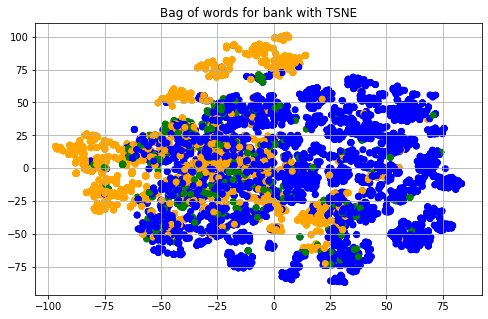

In [143]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(X_embedded[:,0], X_embedded[:,1], c=train['answer'].map({-1: 'orange', 0: 'blue', 1: 'green'}))
plt.title('Bag of words for bank with TSNE')
plt.grid(True)
plt.show()

## VII. Запустим этот же ноутбук на данных tkk

In [21]:
train_filename = "/home/snowowl/PycharmProjects/cft_fs_homework6/tkk_train_2016.xml"
test_filename = "/home/snowowl/PycharmProjects/cft_fs_homework6/tkk_test_etalon.xml"

train_tkk = get_data_tkk(train_filename)
test_tkk = get_data_tkk(test_filename)

In [22]:
train_tkk.head()

,text,answer,company,sample_id
0,"@mkomov Максим, Вашем письмо мы получили. Наши...",0,beeline,1
1,«Мегафон» стал владельцем 50% акций «Евросети»,0,megafon,2
2,RT @fuckkiev: “@EvaKobb: МТС Россия прислала ж...,-1,mts,3
3,ВИДЕО: http://t.co/PSMLAhR4fI Реклама со смехо...,1,mts,4
4,"@parfenov1960 потому что МТС достало, а пчел н...",-1,mts,5


In [23]:
test_tkk.head()

,text,answer,company,sample_id
0,RT vzglyad: По делу о работе МТС в Узбекистане...,-1,mts,1
1,RT @kevinuyatukox: http://t.co/ljtrjq91v3 #Кре...,0,megafon,2
2,#Оформить кредитную карту в банке мтс http://t...,0,mts,3
3,#Как перевести деньги с билайна на кредитную к...,0,beeline,4
4,#Начальник отдела кредитного контроля оао мтс ...,0,mts,5


In [24]:
url_replacement = lambda x: re.sub(r'(?:http[^\s]+)($|\s)', r'url\1', x)
user_replacement = lambda x: re.sub(r'(?:@[^\s]+)($|\s)', r'user\1', x)

train_tkk['text'] = train_tkk['text'].apply(url_replacement)
train_tkk['text'] = train_tkk['text'].apply(user_replacement)

test_tkk['text'] = test_tkk['text'].apply(url_replacement)
test_tkk['text'] = test_tkk['text'].apply(user_replacement)

In [25]:
train_tkk.head()

,text,answer,company,sample_id
0,"user Максим, Вашем письмо мы получили. Наши со...",0,beeline,1
1,«Мегафон» стал владельцем 50% акций «Евросети»,0,megafon,2
2,RT user “user МТС Россия прислала жителям Херс...,-1,mts,3
3,ВИДЕО: url Реклама со смехом МТС - Супер 0,1,mts,4
4,"user потому что МТС достало, а пчел ненавижу с...",-1,mts,5


In [26]:
test_tkk.head()

,text,answer,company,sample_id
0,RT vzglyad: По делу о работе МТС в Узбекистане...,-1,mts,1
1,RT user url #Кредитные карты мегафон банка,0,megafon,2
2,#Оформить кредитную карту в банке мтс url,0,mts,3
3,#Как перевести деньги с билайна на кредитную к...,0,beeline,4
4,#Начальник отдела кредитного контроля оао мтс ...,0,mts,5


In [144]:
vectorizer = CountVectorizer(max_features=100)
X_tkk = vectorizer.fit_transform(train_tkk['text'])
X_tkk.shape

(9209, 100)

In [145]:
decomposition = TSNE(n_components=2, random_state=2020)

In [146]:
%%time
X_embedded = decomposition.fit_transform(X_tkk.toarray())

CPU times: user 3min 53s, sys: 296 ms, total: 3min 54s
Wall time: 1min 16s


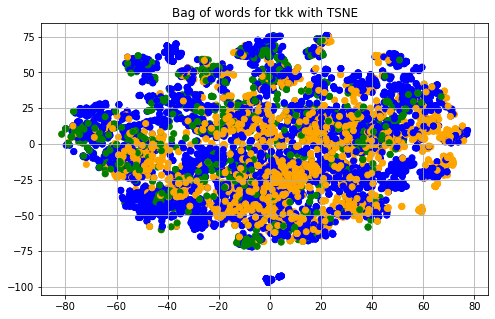

In [147]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(X_embedded[:,0], X_embedded[:,1], c=train_tkk['answer'].map({-1: 'orange', 0: 'blue', 1: 'green'}))
plt.title('Bag of words for tkk with TSNE')
plt.grid(True)
plt.show()

## Вместо мешка слов попробуем TF-IDF

In [148]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(analyzer='word', max_features=100)

In [149]:
X_tkk = tfidf.fit_transform(train_tkk['text'])
X_tkk.shape

(9209, 100)

In [150]:
X_bank = tfidf.fit_transform(train['text'])
X_bank.shape

(10725, 100)

#### TSNE

In [151]:
%%time
X_emb_bank = decomposition.fit_transform(X_bank.toarray())

CPU times: user 4min 2s, sys: 312 ms, total: 4min 2s
Wall time: 1min 21s


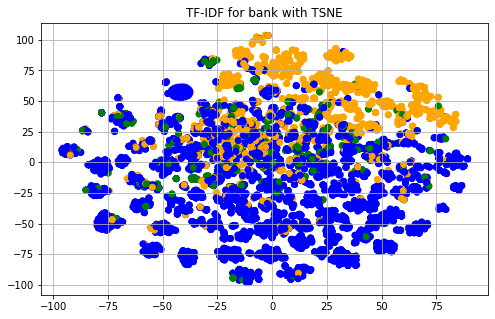

In [152]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(X_emb_bank[:,0], X_emb_bank[:,1], c=train['answer'].map({-1: 'orange', 0: 'blue', 1: 'green'}))
plt.title('TF-IDF for bank with TSNE')
plt.grid(True)
plt.show()

In [153]:
%%time
X_emb_tkk = decomposition.fit_transform(X_tkk.toarray())

CPU times: user 3min 23s, sys: 221 ms, total: 3min 23s
Wall time: 1min 5s


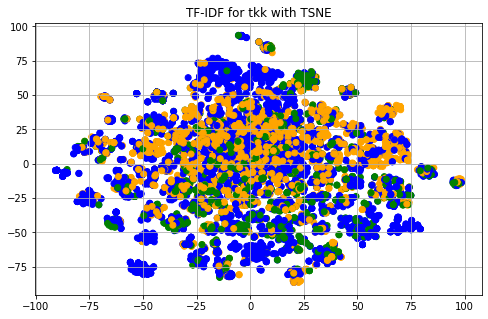

In [154]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(X_emb_tkk[:,0], X_emb_tkk[:,1], c=train_tkk['answer'].map({-1: 'orange', 0: 'blue', 1: 'green'}))
plt.title('TF-IDF for tkk with TSNE')
plt.grid(True)
plt.show()

#### PCA

In [155]:
%%time
from sklearn import decomposition
pca = decomposition.PCA(n_components=2, random_state=2020)
X_emb_bank = pca.fit_transform(X_bank.toarray())

CPU times: user 218 ms, sys: 116 ms, total: 334 ms
Wall time: 120 ms


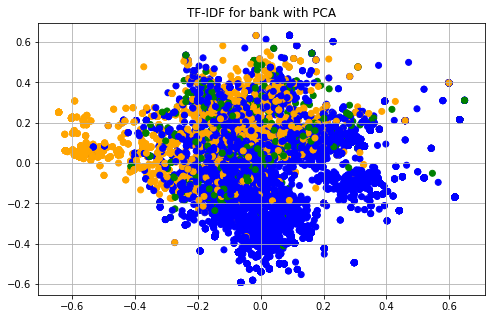

In [156]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(X_emb_bank[:,0], X_emb_bank[:,1], c=train['answer'].map({-1: 'orange', 0: 'blue', 1: 'green'}))
plt.title('TF-IDF for bank with PCA')
plt.grid(True)
plt.show()

In [157]:
X_emb_tkk = pca.fit_transform(X_tkk.toarray())

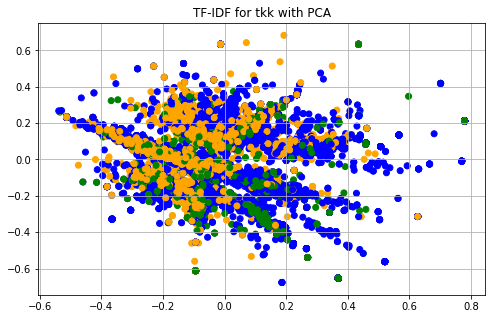

In [158]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(X_emb_tkk[:,0], X_emb_tkk[:,1], c=train_tkk['answer'].map({-1: 'orange', 0: 'blue', 1: 'green'}))
plt.title('TF-IDF for tkk with PCA')
plt.grid(True)
plt.show()

#### UMAP

In [159]:
%%time

import umap
ump = umap.UMAP(n_components=2, random_state=2020)

X_emb_bank = ump.fit_transform(X_bank.toarray())

CPU times: user 19.3 s, sys: 2.4 s, total: 21.7 s
Wall time: 16.7 s


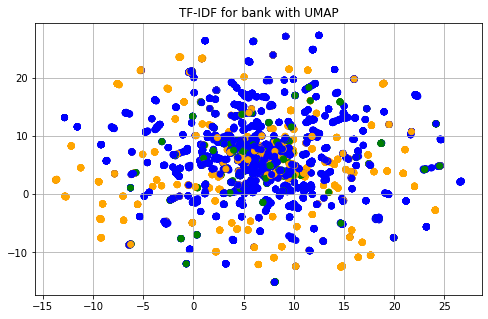

In [160]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(X_emb_bank[:,0], X_emb_bank[:,1], c=train['answer'].map({-1: 'orange', 0: 'blue', 1: 'green'}))
plt.title('TF-IDF for bank with UMAP')
plt.grid(True)
plt.show()

In [161]:
X_emb_tkk = ump.fit_transform(X_tkk.toarray())

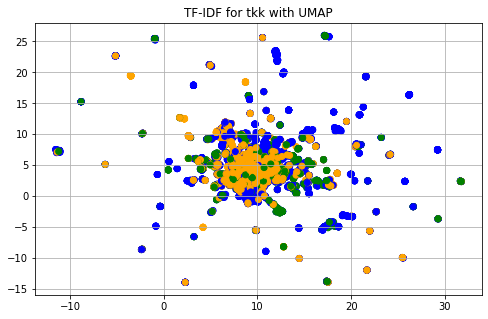

In [162]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(X_emb_tkk[:,0], X_emb_tkk[:,1], c=train_tkk['answer'].map({-1: 'orange', 0: 'blue', 1: 'green'}))
plt.title('TF-IDF for tkk with UMAP')
plt.grid(True)
plt.show()

#### random_projection

In [163]:
from sklearn.random_projection import GaussianRandomProjection

rp = GaussianRandomProjection(random_state=2020, n_components=2)
X_emb_bank = rp.fit_transform(X_bank.toarray())
X_emb_bank.shape

(10725, 2)

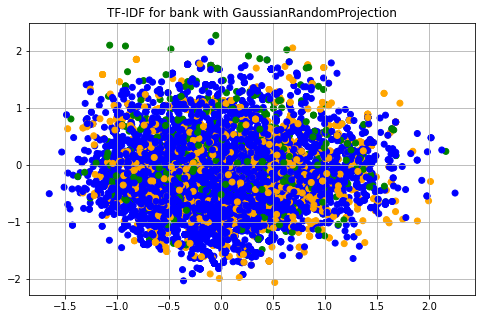

In [164]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(X_emb_bank[:,0], X_emb_bank[:,1], c=train['answer'].map({-1: 'orange', 0: 'blue', 1: 'green'}))
plt.title('TF-IDF for bank with GaussianRandomProjection')
plt.grid(True)
plt.show()

In [165]:
X_emb_tkk = rp.fit_transform(X_tkk.toarray())
X_emb_tkk.shape

(9209, 2)

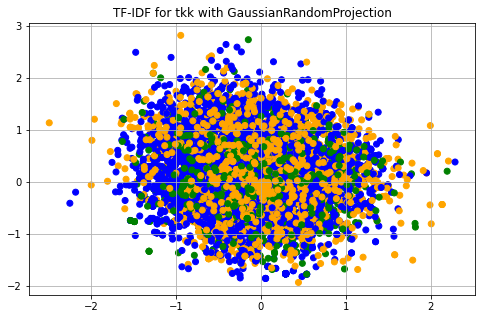

In [166]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(X_emb_tkk[:,0], X_emb_tkk[:,1], c=train_tkk['answer'].map({-1: 'orange', 0: 'blue', 1: 'green'}))
plt.title('TF-IDF for tkk with GaussianRandomProjection')
plt.grid(True)
plt.show()

## FastText

In [74]:
!ls -la

итого 47604
drwxrwxr-x  5 snowowl snowowl     4096 ноя  5 00:41 .
drwxrwxr-x 13 snowowl snowowl     4096 ноя  5 00:12 ..
drwxrwxr-x  2 snowowl snowowl     4096 ноя  5 00:38 181
-rw-rw-r--  1 snowowl snowowl 14898979 ноя  3 20:31 banks_test_2016.xml
-rw-rw-r--  1 snowowl snowowl  2684937 ноя  3 20:31 banks_test_etalon.xml
-rw-rw-r--  1 snowowl snowowl  7277552 ноя  3 20:27 bank_train_2016.xml
-rw-rw-r--  1 snowowl snowowl  1110913 ноя  5 00:41 Features_word_level.ipynb
drwxrwxr-x  2 snowowl snowowl     4096 ноя  4 14:51 .ipynb_checkpoints
drwxrwxr-x  7 snowowl snowowl     4096 ноя  4 23:29 nlp
-rw-rw-r--  1 snowowl snowowl 14636111 ноя  3 20:32 tkk_test_2016.xml
-rw-rw-r--  1 snowowl snowowl  1709108 ноя  3 20:32 tkk_test_etalon.xml
-rw-rw-r--  1 snowowl snowowl  6391728 ноя  3 20:32 tkk_train_2016.xml


In [76]:
import gensim
model = gensim.models.KeyedVectors.load('181/model.model')

In [78]:
model["куку"]

array([-0.00296784,  0.1947115 ,  0.52625775,  0.39905536, -0.27364528,
       -0.01536282,  0.03818725,  0.23093444, -0.0551637 , -0.10007454,
       -0.44373977,  0.20660451,  0.28840637, -0.41925228,  0.14498287,
        0.16983645, -0.04566146,  0.23128168, -0.03944245,  0.21226472,
       -0.41558653,  0.08801638,  0.11307734, -0.06979934, -0.0097214 ,
        0.07263824,  0.05620824, -0.14806645,  0.35194167,  0.172066  ,
       -0.43698296, -0.12684822, -0.21499002, -0.03457339, -0.03549154,
        0.23319997, -0.00290691,  0.08414913,  0.26712644,  0.09097573,
       -0.16478528, -0.11838078,  0.13538484,  0.22087407, -0.14097059,
        0.01925237, -0.01664282, -0.02799122, -0.19373639, -0.0536807 ,
        0.1361174 ,  0.5166878 , -0.06879478, -0.01188826, -0.37798637,
        0.13728738, -0.21550705,  0.3008633 ,  0.15207118, -0.32287186,
       -0.26013038, -0.10156683,  0.31808707, -0.25897062,  0.0171144 ,
        0.2729003 , -0.4328185 ,  0.01800041, -0.28583258, -0.21

In [79]:
for n in model.most_similar(positive=['комок']):
    print(n[0], round(n[1], 3))

комочек 0.8
комочка 0.725
ком 0.689
цмок 0.651
ошметок 0.627
клубочка 0.622
клубочек 0.619
слипшихся 0.617
комо 0.6
пупырышек 0.594


In [167]:
twit_emb = lambda x: np.mean([model[word] for word in x.split()], axis=0)
X_ft_bank = np.stack(train['text'].apply(twit_emb).values)
X_ft_tkk = np.stack(train_tkk['text'].apply(twit_emb).values)
X_ft_bank.shape, X_ft_tkk.shape

((10725, 300), (9209, 300))

#### Попробуем визуализировать с помощью PCA, он быстрее всего.

In [168]:
%%time
from sklearn import decomposition
pca = decomposition.PCA(n_components=2, random_state=2020)
X_emb_bank = pca.fit_transform(X_ft_bank)

CPU times: user 334 ms, sys: 220 ms, total: 554 ms
Wall time: 181 ms


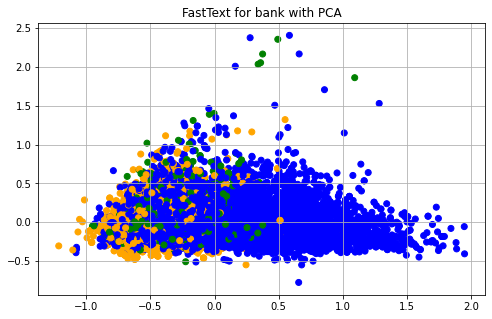

In [169]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(X_emb_bank[:,0], X_emb_bank[:,1], c=train['answer'].map({-1: 'orange', 0: 'blue', 1: 'green'}))
plt.title('FastText for bank with PCA')
plt.grid(True)
plt.show()

In [170]:
X_emb_tkk = pca.fit_transform(X_ft_tkk)

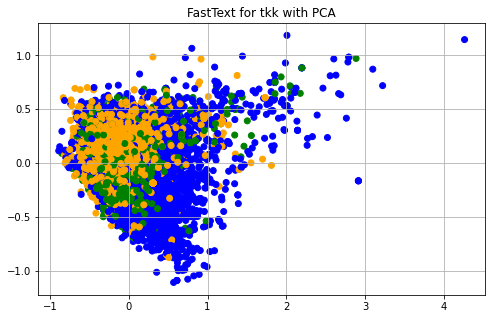

In [171]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(X_emb_tkk[:,0], X_emb_tkk[:,1], c=train_tkk['answer'].map({-1: 'orange', 0: 'blue', 1: 'green'}))
plt.title('FastText for tkk with PCA')
plt.grid(True)
plt.show()